<a href="https://colab.research.google.com/github/egjlmn1/Simpsonize/blob/main/Simpsonize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating the Model


## Technical preperations

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tfds-nightly

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

import glob
import os
import time
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
HUMAN_IMG_WIDTH = 600
HUMAN_IMG_HEIGHT = 600
SIMPLIFIED_IMG_WIDTH = 200
SIMPLIFIED_IMG_HEIGHT = 200
IMG_SIZE = 256

## Importing Data

In [ ]:
cd drive/MyDrive/DeepPerceptionLearning

[Errno 2] No such file or directory: 'drive/MyDrive/DeepPerceptionLearning'
/content/drive/My Drive/DeepPerceptionLearning


### Now we build the dataset so we can load it later

In [ ]:
!mkdir /root/tensorflow_datasets

!mkdir /root/tensorflow_datasets/human_big_eyeless_bg_dataset
!cp -R /content/drive/MyDrive/DeepPerceptionLearning/saved_datasets/human_big_eyeless_bg_dataset /root/tensorflow_datasets/human_big_eyeless_bg_dataset/1.0.0/


mkdir: cannot create directory ‘/root/tensorflow_datasets’: File exists
mkdir: cannot create directory ‘/root/tensorflow_datasets/human_big_eyeless_bg_dataset’: File exists


In [ ]:
cd human_big_eyeless_bg_dataset

/content/drive/MyDrive/DeepPerceptionLearning/human_big_eyeless_bg_dataset


In [ ]:
!tfds build --manual_dir='' human_big_eyeless_bg_dataset

2021-04-10 11:50:06.450888: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
INFO[build.py]: Loading dataset human_big_eyeless_bg_dataset from path: /content/drive/MyDrive/DeepPerceptionLearning/human_big_eyeless_bg_dataset/human_big_eyeless_bg_dataset.py
INFO[dataset_info.py]: Load dataset info from /root/tensorflow_datasets/human_big_eyeless_bg_dataset/1.0.0
INFO[build.py]: download_and_prepare for dataset human_big_eyeless_bg_dataset/1.0.0...
INFO[dataset_builder.py]: Reusing dataset human_big_eyeless_bg_dataset (/root/tensorflow_datasets/human_big_eyeless_bg_dataset/1.0.0)
INFO[build.py]: Dataset generation complete...

tfds.core.DatasetInfo(
    name='human_big_eyeless_bg_dataset',
    full_name='human_big_eyeless_bg_dataset/1.0.0',
    description="""
    
    """,
    homepage='https://www.tensorflow.org/datasets/catalog/human_big_eyeless_bg_dataset',
    data_path='/root/tensorflow_datasets/human_big_eyeless_b

In [ ]:
cd ../hairy_simpsons_dataset

/content/drive/MyDrive/DeepPerceptionLearning/hairy_simpsons_dataset


In [ ]:
!tfds build --manual_dir='' hairy_simpsons_dataset

In [ ]:
cd ..

### Now we load the datasets

In [ ]:
human_dataset = tfds.load('human_big_eyeless_bg_dataset')['train']
simpson_dataset = tfds.load('hairy_simpsons_dataset')['train']

## Image Proccessing

In [ ]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_SIZE, IMG_SIZE, 3])

  return cropped_image

In [ ]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / (IMG_SIZE / 2)) - 1
  return image

In [ ]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [IMG_SIZE+30, IMG_SIZE+30],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [ ]:
def preprocess_image(image):
  image = image['image']
  image = random_jitter(image)
  image = normalize(image)
  return image


In [ ]:
human_dataset = human_dataset.map(
    preprocess_image, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

simpson_dataset = simpson_dataset.map(
    preprocess_image, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)


In [ ]:
sample_human = next(iter(human_dataset))
plt.subplot(121)
plt.title('Human')
plt.imshow(sample_human[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Human with random jitter')
plt.imshow(random_jitter(sample_human[0]) * 0.5 + 0.5)

In [ ]:
sample_simpson = next(iter(simpson_dataset))
plt.subplot(121)
plt.title('Simpson')
plt.imshow(sample_simpson[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Simpson with random jitter')
plt.imshow(random_jitter(sample_simpson[0]) * 0.5 + 0.5)

## Prepere Cycle-gan

### Loss functions

In [ ]:
LAMBDA = 10

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [ ]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

In [ ]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

### The Model

In [14]:
class InstanceNormalization(tf.keras.layers.Layer):
  """Instance Normalization Layer (https://arxiv.org/abs/1607.08022)."""

  def __init__(self, epsilon=1e-5):
    super(InstanceNormalization, self).__init__()
    self.epsilon = epsilon

  def build(self, input_shape):
    self.scale = self.add_weight(
        name='scale',
        shape=input_shape[-1:],
        initializer=tf.random_normal_initializer(1., 0.02),
        trainable=True)

    self.offset = self.add_weight(
        name='offset',
        shape=input_shape[-1:],
        initializer='zeros',
        trainable=True)

  def call(self, x):
    mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
    inv = tf.math.rsqrt(variance + self.epsilon)
    normalized = (x - mean) * inv
    return self.scale * normalized + self.offset


def downsample(filters, size, apply_norm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  layers = tf.keras.Sequential(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False),                   
  )
  if apply_norm:
    layers.add(InstanceNormalization())
  layers.add(tf.keras.layers.LeakyReLU())
  return layers


def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  layers = tf.keras.Sequential(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False),
  )
  layers.add(InstanceNormalization())
  if apply_dropout:
    layers.add(tf.keras.layers.Dropout(0.5))
  layers.add(tf.keras.layers.ReLU())
  
  return layers


def generator(output_channels):
  down_stack = [
      downsample(64, 2, apply_norm=False),  # (bs, 128, 128, 64)
      downsample(128, 4),  # (bs, 64, 64, 128)
      downsample(256, 4),  # (bs, 32, 32, 256)
      downsample(512, 4),  # (bs, 16, 16, 512)
      downsample(512, 4),  # (bs, 8, 8, 512)
      downsample(512, 4),  # (bs, 4, 4, 512)
      downsample(512, 4),  # (bs, 2, 2, 512)
      downsample(512, 4),  # (bs, 1, 1, 512)
  ]

  up_stack = [
      upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
      upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
      upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
      upsample(512, 4),  # (bs, 16, 16, 1024)
      upsample(256, 4),  # (bs, 32, 32, 512)
      upsample(128, 4),  # (bs, 64, 64, 256)
      upsample(64, 4),  # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 4, strides=2,
      padding='same', kernel_initializer=initializer,
      activation='tanh')  # (bs, 256, 256, 3)

  concat = tf.keras.layers.Concatenate()

  inputs = tf.keras.layers.Input(shape=[None, None, 3])
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


def discriminator():

  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')
  x = inp

  down1 = downsample(64, 4, False)(x)  # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(
      512, 4, strides=1, kernel_initializer=initializer,
      use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

  norm1 = InstanceNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(
      1, 4, strides=1,
      kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=inp, outputs=last)


In [15]:
OUTPUT_CHANNELS = 3
import pickle
import os

class myCycleGanModel:
  def __init__(self, model_type):
    self.model_type = model_type
    self.epoch = 0
    self.generator1 = generator(OUTPUT_CHANNELS)
    self.generator2 = generator(OUTPUT_CHANNELS)
    self.discriminator1 = discriminator()
    self.discriminator2 = discriminator()
    self.generator1_optimizer = tf.keras.optimizers.Adam(0.0004, beta_1=0.5)
    self.generator2_optimizer = tf.keras.optimizers.Adam(0.0004, beta_1=0.5)
    self.discriminator1_optimizer = tf.keras.optimizers.Adam(0.0004, beta_1=0.5)
    self.discriminator2_optimizer = tf.keras.optimizers.Adam(0.0004, beta_1=0.5)

    self.ckpt = tf.train.Checkpoint(generator1=self.generator1,
                           generator2=self.generator2,
                           discriminator1=self.discriminator1,
                           discriminator2=self.discriminator2,
                           generator1_optimizer=self.generator1_optimizer,
                           generator2_optimizer=self.generator2_optimizer,
                           discriminator1_optimizer=self.discriminator1_optimizer,
                           discriminator2_optimizer=self.discriminator2_optimizer)
    self.ckpt_manager = tf.train.CheckpointManager(self.ckpt, "models/"+self.model_type, max_to_keep=2)


  def save(self):
    pickle.dump( self.epoch, open( "models/"+self.model_type+'/'+self.model_type, "wb" ) )
    self.ckpt_manager.save()
    print ('Saving model at {}'.format("models/"+self.model_type))
      
  def load(self):
    if self.ckpt_manager.latest_checkpoint:
      self.ckpt.restore(self.ckpt_manager.latest_checkpoint)
      self.epoch = pickle.load( open("models/"+self.model_type+'/'+self.model_type, "rb" ))
      print ('Latest checkpoint restored!!')

  def forward(self, sample_input,display=True):
    to_output = self.generator1(sample_input)
    if not display:
      return to_output
    plt.figure(figsize=(8, 8))
    contrast = 8

    imgs = [sample_input, to_output]
    title = ['Input', 'To Output']

    for i in range(len(imgs)):
      plt.subplot(1, len(imgs), i+1)
      plt.title(title[i])
      if i % 2 == 0:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
      else:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
    plt.show()
    return to_output

  
  @tf.function
  def train_step(self, real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
      # Generator G translates X -> Y
      # Generator F translates Y -> X.

      fake_y = self.generator1(real_x, training=True)
      cycled_x = self.generator2(fake_y, training=True)

      fake_x = self.generator2(real_y, training=True)
      cycled_y = self.generator1(fake_x, training=True)

      # same_x and same_y are used for identity loss.
      same_x = self.generator2(real_x, training=True)
      same_y = self.generator1(real_y, training=True)

      disc_real_x = self.discriminator1(real_x, training=True)
      disc_real_y = self.discriminator2(real_y, training=True)

      disc_fake_x = self.discriminator1(fake_x, training=True)
      disc_fake_y = self.discriminator2(fake_y, training=True)

      # calculate the loss
      gen1_loss = generator_loss(disc_fake_y)
      gen2_loss = generator_loss(disc_fake_x)

      total_cycle_loss = 0.4 * calc_cycle_loss(real_x, cycled_x) + 1.6 * calc_cycle_loss(real_y, cycled_y)

      # Total generator loss = adversarial loss + cycle loss
      total_gen1_loss = 0.75 * gen1_loss + 0.75 * total_cycle_loss + 1.5 * identity_loss(real_y, same_y)
      total_gen2_loss = 0.75 * gen2_loss + 0.75 * total_cycle_loss + 1.5 * identity_loss(real_x, same_x)

      disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
      disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate the gradients for generator and discriminator

    generator1_gradients = tape.gradient(total_gen1_loss, 
                                          self.generator1.trainable_variables)
    generator2_gradients = tape.gradient(total_gen2_loss, 
                                          self.generator2.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                              self.discriminator1.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                              self.discriminator2.trainable_variables)

    # Apply the gradients to the optimizer
    self.generator1_optimizer.apply_gradients(zip(generator1_gradients, 
                                              self.generator1.trainable_variables))

    self.generator2_optimizer.apply_gradients(zip(generator2_gradients, 
                                              self.generator2.trainable_variables))

    self.discriminator1_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                  self.discriminator1.trainable_variables))

    self.discriminator2_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                  self.discriminator2.trainable_variables))
    

In [ ]:
my_model = myCycleGanModel('shachar_testing1')
my_model.load()
my_model.epoch

## Training

In [ ]:
def train_cycle_gan(model, epochs_num, input_dataset, output_dataset, sample_input, sample_output):
  while model.epoch < epochs_num:
    start = time.time()
    model.forward(sample_input)
    # model.forward_output(sample_output)
    print('start')
    n = 0
    for image_x, image_y in tf.data.Dataset.zip((input_dataset, output_dataset)):
      n+=1
      model.train_step(image_x, image_y)
      if n%25 == 0:
        print (n, end=', ')
      if n == 3000:
        break
    model.epoch += 1

    clear_output(wait=True)
    # Using a consistent image (sample_human) so that the progress of the model
    # is clearly visible.
    

    if model.epoch % 10 == 0:
      model.save()
      print(f'saved model at epoch {model.epoch}')

    print ('Time taken for epoch {} is {} sec\n'.format(model.epoch,
                                                        time.time()-start))

In [ ]:
train_cycle_gan(my_model, 40, human_dataset, simpson_dataset, sample_human, sample_simpson)

Saving model at models/shachar_testing1
saved model at epoch 40
Time taken for epoch 40 is 436.3392777442932 sec



# Showing Result

## Technical preperation

In [3]:
!pip install gluoncv

     |████████████████████████████████| 1.1MB 17.7MB/s 
     |████████████████████████████████| 122kB 54.8MB/s 
     |████████████████████████████████| 14.1MB 218kB/s 
     |████████████████████████████████| 317kB 53.5MB/s 
     |████████████████████████████████| 215kB 56.1MB/s 
     |████████████████████████████████| 133kB 56.3MB/s 
     |████████████████████████████████| 686kB 46.9MB/s 
     |████████████████████████████████| 952kB 44.3MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 3.2MB 45.3MB/s 
     |████████████████████████████████| 71kB 9.7MB/s 
     |████████████████████████████████| 962kB 52.7MB/s 
     |████████████████████████████████| 81kB 10.4MB/s 
     |████████████████████████████████| 7.4MB 55.3MB/s 
  Created wheel for ConfigSpace: filename=ConfigSpace-0.4.18-cp37-cp37m-linux_x86_64.whl size=2879765 sha256=5755d8134a5e8e4db476707aa803ccd02a83535a

In [4]:
!pip install mxnet

     |████████████████████████████████| 46.9MB 56kB/s 


In [5]:
!pip install aggdraw

     |████████████████████████████████| 798kB 20.9MB/s 


In [6]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [7]:
cd /content/

/content


In [8]:
import tensorflow as tf
import tensorflow_datasets as tfds

import glob
import os
import time
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from IPython.display import clear_output

from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf


## Image processing

In [9]:
import os

def save_input(name=None):
  if name is None:
    name = '2.PNG'
  for x in os.listdir('drive/MyDrive/DeepPerceptionLearning/test'):
    if x.startswith(name):
      name = x
      break
  INPUT_IMAGE = '/content/drive/MyDrive/DeepPerceptionLearning/test/' + name
  img = Image.open(INPUT_IMAGE).convert('RGB')
  if img.width > img.height:
    img = img.crop((img.width/2-img.height/2,0,img.width/2+img.height/2,img.height))
  elif img.width < img.height:
    img = img.crop((0,img.height/2-img.width/2,img.width,img.height/2+img.width/2))
  img.thumbnail((256,256))
  img.save('/content/image.jpg', "JPEG")

In [10]:
def remove_background():
  !python /content/drive/MyDrive/DeepPerceptionLearning/background/background_remover.py '/content/image.jpg'

In [11]:
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / (256 / 2)) - 1
  return image

import dlib
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/drive/MyDrive/DeepPerceptionLearning/models/shape_68.dat')

from aggdraw import Draw, Brush, Pen

def mark_eyes(pil_img):
  np_img = np.asarray(pil_img)
  detect=detector(np_img,1)
  try:
    shape=predictor(np_img,detect[0])
  except Exception:
    print('Failed to preprocess the image, showing best result without preproccessing')
    return pil_img
  eyes = [[18,19,20,21,39,40,41,36],[22,23,24,25,45,46,47,42]]

  for eye in eyes:
    l = []
    l.append(shape.part(eye[0]).x)
    l.append(shape.part(eye[0]).y)
    l.append(shape.part(eye[1]).x)
    l.append(shape.part(eye[1]).y)
    l.append(shape.part(eye[2]).x)
    l.append(shape.part(eye[2]).y)
    l.append(shape.part(eye[3]).x)
    l.append(shape.part(eye[3]).y)
    l.append(shape.part(eye[4]).x)
    l.append(shape.part(eye[4]).y)
    l.append(shape.part(eye[5]).x)
    l.append(shape.part(eye[5]).y)
    l.append(shape.part(eye[6]).x)
    l.append(shape.part(eye[6]).y)
    l.append(shape.part(eye[7]).x)
    l.append(shape.part(eye[7]).y)
    middle = get_middle_point([(l[2*i],l[2*i+1]) for i in range(len(l)//2)])
      
    draw = Draw(pil_img)
    draw.polygon(l, Pen('black'), Brush('white'))
    draw.ellipse((middle[0]-6, middle[1]-6, middle[0]+6, middle[1]+6), Pen('black'), Brush('black'))
    draw.flush()
  return pil_img

def get_middle_point(points):
  x = sum([point[0] for point in points])
  y = sum([point[1] for point in points])
  return (x/len(points), y/len(points))

def get_input(rewrite=True):
  if rewrite or not os.path.exists('/content/backgroundless.jpg'):
    remove_background()
  img = Image.open('/content/backgroundless.jpg')
  image = np.array(mark_eyes(img.convert('RGB')))
  image = tf.image.resize(image, [256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return tf.reshape(normalize(image),[1,256,256,3])

In [12]:
import numpy as np
from sklearn.cluster import KMeans

def postprocess(img):
  array = np.array(img)
  n_colors = 6

  array = array.reshape(-1,3)

  kmeans = KMeans(n_clusters=n_colors, random_state=2).fit(array)
  labels = kmeans.labels_
  centers = kmeans.cluster_centers_
  less_colors = centers[labels].reshape(array.shape).astype('uint8')
  img2 = Image.fromarray(np.uint8(less_colors.reshape(256,256,3)))

  return img2

def fix_eyes(img):
  img2 = img.copy()
  pixels = img.load()
  pixels2 = img2.load()
  for y in range(img.height):
    for x in range(13,img.width-13):
      p = pixels[x,y]
      
      if (pixels[x-13,y] == pixels[x+13,y]):
        if (pixels[x+13,y][0]>150) and (pixels[x+13,y][1]>150) and (pixels[x+13,y][2]>150):
          if (pixels[x+13,y] != p) and not ((p[2] < 30) and (p[1] > 150) and (p[0] > 150)):
            pixels2[x,y] = (0,0,0)
  return img2

## The Model

In [20]:
OUTPUT_CHANNELS = 3
import pickle
import os

class myCycleGanModel:
  def __init__(self, model_type):
    self.model_type = model_type
    self.epoch = 0
    self.generator1 = generator(OUTPUT_CHANNELS)
    self.generator2 = generator(OUTPUT_CHANNELS)
    self.discriminator1 = discriminator()
    self.discriminator2 = discriminator()
    self.generator1_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    self.generator2_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    self.discriminator1_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5) # increasing learning rate
    self.discriminator2_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    self.ckpt = tf.train.Checkpoint(generator1=self.generator1,
                           generator2=self.generator2,
                           discriminator1=self.discriminator1,
                           discriminator2=self.discriminator2,
                           generator1_optimizer=self.generator1_optimizer,
                           generator2_optimizer=self.generator2_optimizer,
                           discriminator1_optimizer=self.discriminator1_optimizer,
                           discriminator2_optimizer=self.discriminator2_optimizer)
    self.ckpt_manager = tf.train.CheckpointManager(self.ckpt, "/content/drive/MyDrive/DeepPerceptionLearning/models/"+self.model_type, max_to_keep=2)



  def save(self):
    pickle.dump( self.epoch, open( "/content/drive/MyDrive/DeepPerceptionLearning/models/"+self.model_type+'/'+self.model_type, "wb" ) )
    self.ckpt_manager.save()
    print ('Saving model at {}'.format("/content/drive/MyDrive/DeepPerceptionLearning/models/"+self.model_type))
      
  def load(self):
    if self.ckpt_manager.latest_checkpoint:
      self.ckpt.restore(self.ckpt_manager.latest_checkpoint)
      self.epoch = pickle.load( open("/content/drive/MyDrive/DeepPerceptionLearning/models/"+self.model_type+'/'+self.model_type, "rb" ))
      print ('Latest checkpoint restored!!')

  def forward(self, sample_input):
    to_output = self.generator1(sample_input)
    return to_output

In [21]:
my_model = myCycleGanModel('shachar_testing1')
my_model.load()
my_model.epoch

Latest checkpoint restored!!


40

## Displaying Results

In [22]:
def simpsonize(name=None):
  save_input(name)
  tf.keras.preprocessing.image.save_img('output.jpg', my_model.forward(get_input(rewrite=True))[0])
  img = Image.open('output.jpg')
  return img

In [32]:
def display(output):
  post = postprocess(output)
  imgs = [Image.open('image.jpg'), output, post, fix_eyes(post)]
  imgs = [imgs[0], imgs[-1]]
  clear_output(wait=True)
  titles = ['input','output']
  plt.figure(figsize=(8, 8))
  plt.subplot(1, len(imgs), 1)
  for i, img in enumerate(imgs):
    plt.title(titles[i])
    plt.subplot(1, len(imgs), i+1)
    plt.imshow(img)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


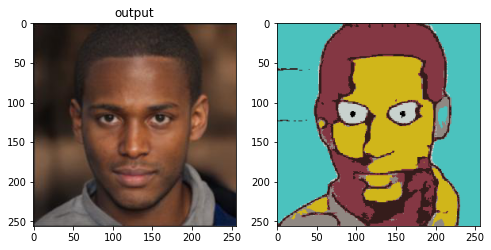

In [33]:
output = simpsonize('article1')
display(output)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


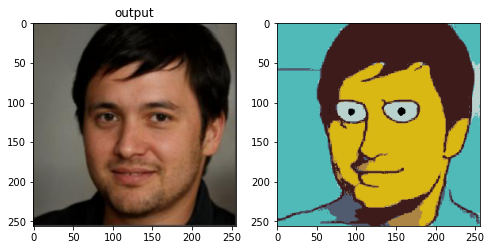

In [34]:
output = simpsonize('article2')
display(output)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


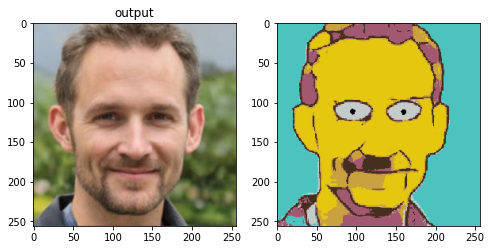

In [35]:
output = simpsonize('article3')
display(output)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


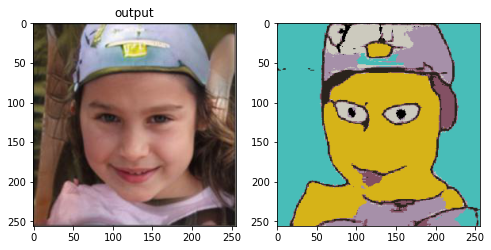

In [36]:
output = simpsonize('article4')
display(output)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


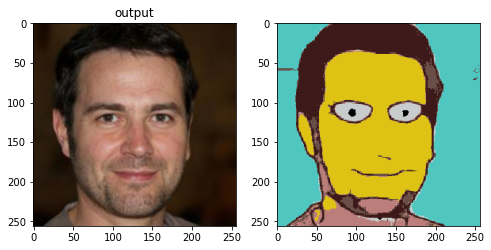

In [37]:
output = simpsonize('article5')
display(output)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


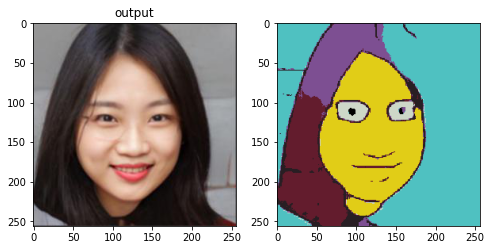

In [38]:
output = simpsonize('article6')
display(output)